# Analysis of empty partitions

**Author**: Sandro Campos

This notebook aims to achieve a deeper understanding of the empty partitions a catalog may contain after filtering of some kind.

In [21]:
import lsdb
import healpy as hp
import numpy as np

import matplotlib.pyplot as plt

### Initialize a Dask Client

In [ ]:
from dask.distributed import Client

client = Client(n_workers=4)
client

/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38113 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38113/status,
Dashboard: http://127.0.0.1:38113/status,Workers: 4
Total threads: 96,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45445,Workers: 4
Dashboard: http://127.0.0.1:38113/status,Total threads: 96
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:38550,Total threads: 24
Dashboard: http://127.0.0.1:40699/status,Memory: 251.90 GiB
Nanny: tcp://127.0.0.1:37889,


### Utility methods

In [3]:
from hipscat.inspection import plot_pixels

def construct_density_map(pixel_map, partition_sizes):
    # Compute density for each pixel, at each order
    density_map = {}
    for pixel, partition_idx in pixel_map.items():
        pixel_area = hp.nside2pixarea(hp.order2nside(pixel.order))
        density_map[pixel] = partition_sizes[partition_idx] / pixel_area
    return density_map
    
def explode_pixel_map(density_map, max_order, binary):
    # Explode density map to maximum order
    exploded_density_map = np.full(hp.order2npix(max_order),  hp.pixelfunc.UNSEEN)
    for pixel, density in density_map.items():
        explosion_factor = 4 ** (max_order - pixel.order)
        exploded_pixels = [
            *range(
                pixel.pixel * explosion_factor,
                (pixel.pixel + 1) * explosion_factor,
            )
        ]
        if binary:
            # Pixel value is 1 if it has points, 2 if does not
            exploded_density_map[exploded_pixels] = 1 if density > 0 else 2
        else:
            # Pixel values correspond to density
            exploded_density_map[exploded_pixels] = density
    return exploded_density_map

def plot_density_map(pixel_map, partition_sizes):  
    density_map = construct_density_map(pixel_map, partition_sizes)
    pixels = list(pixel_map.keys())
    max_order = np.max(pixels).order
    exploded_density_map = explode_pixel_map(density_map, max_order, binary=False)
    hp.mollview(exploded_density_map, nest=True, title="Pixel density map")
    
def plot_non_empty_pixel_map(pixel_map, partition_sizes):
    density_map = construct_density_map(pixel_map, partition_sizes)
    pixels = list(pixel_map.keys())
    max_order = np.max(pixels).order
    exploded_density_map = explode_pixel_map(density_map, max_order, binary=True)
    hp.mollview(exploded_density_map, nest=True, title="Pixel non-empty map", unit="1 if has data, 2 if not")

### Load ZTF and Gaia

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,
12490637312,108000449961107213,44.996152,0.005626,18.113300,17.627800,17.406500,364,381,18,18.143208,17.569102,17.373423,3,0,0
98125742080,108020450140974134,45.014110,0.019775,21.565901,21.134199,21.414301,42,114,1,21.298568,21.007693,20.599543,3,0,0
104371060736,108010450069569645,45.007042,0.015954,22.047899,21.641199,21.655001,5,17,0,21.552179,21.405765,NaN,3,0,0
116614234112,108020450049144323,45.004993,0.019910,14.892500,14.105700,13.792100,371,387,18,14.916993,14.028394,13.727368,3,0,0
118560391168,108020450042525676,45.004327,0.021077,19.278601,18.040701,16.853201,126,302,15,19.344950,17.897595,16.653296,3,0,0


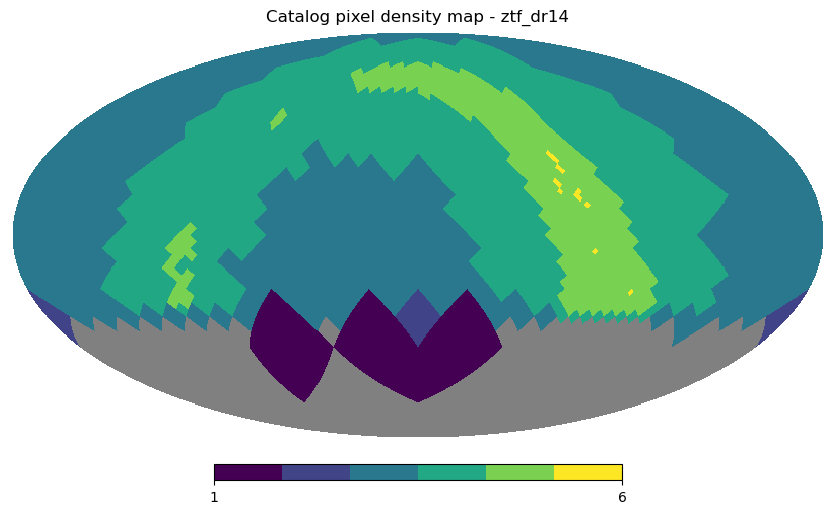

In [4]:
ztf_dr14 = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")
plot_pixels(ztf_dr14.hc_structure)
ztf_dr14.head(n=5)

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
12482248704,1636148068921376768,Gaia DR3 4295806720,4295806720,545300884,2016.0,44.996155,0.101618,0.005615,0.101334,0.354331,...,0.0052,0.0013,0.0143,0.0028,0.0007,0.0078,MARCS,2,0,0
116614234112,1636148068921376768,Gaia DR3 38655544960,38655544960,1757259052,2016.0,45.004978,0.017885,0.019880,0.018772,3.139170,...,0.1820,0.1425,0.1955,0.0961,0.0752,0.1032,MARCS,2,0,0
118560391168,1636148068921376768,Gaia DR3 34361129088,34361129088,894504938,2016.0,45.004320,0.097320,0.021048,0.101753,3.235017,...,0.5050,0.4815,0.5273,0.3096,0.2956,0.3228,MARCS,2,0,0
648842051584,1636148068921376768,Gaia DR3 309238066432,309238066432,327609758,2016.0,44.995037,0.322039,0.038152,0.283505,1.383150,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,2,0,0
751493447680,1636148068921376768,Gaia DR3 343597448960,343597448960,1791600903,2016.0,44.963896,0.117176,0.043595,0.109004,0.196148,...,0.0065,0.0018,0.0158,0.0035,0.0009,0.0084,PHOENIX,2,0,0


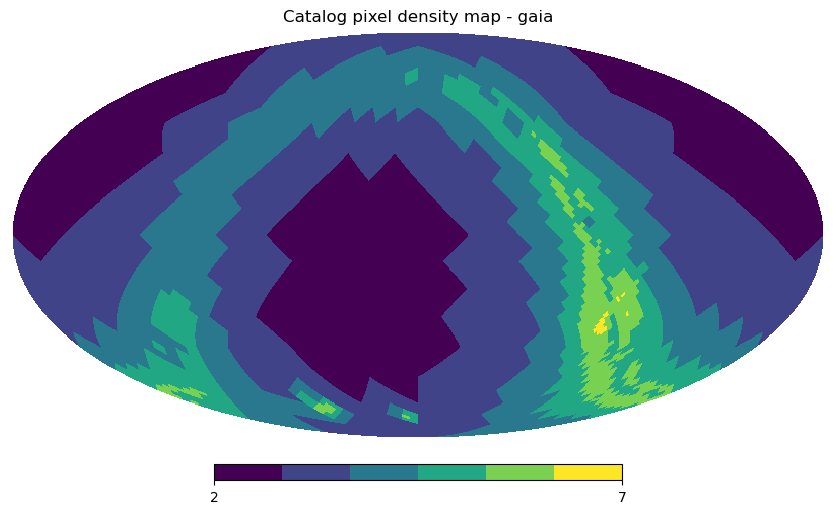

In [8]:
gaia_dr3 = lsdb.read_hipscat("/astro/store/epyc3/data3/hipscat/catalogs/gaia_dr3/gaia")
plot_pixels(gaia_dr3.hc_structure)
gaia_dr3.head()

Gaia is an all-sky coverage survey, unlike ZTF. 

## Premise

A user often expects to have a catalog after filtering containing __non-empty partitions__ with points for the selected filter. This is not always the case because for the cone, polygonal and box searches we make HEALpy return all the pixels that __overlap__ with the filter, not only those whose centers lie in it. This is necessary to prevent information loss!

For more information refer to [`query_disc`](https://healpy.readthedocs.io/en/latest/generated/healpy.query_disc.html), [`query_polygon`](https://healpy.readthedocs.io/en/latest/generated/healpy.query_polygon.html) and [`query_strip`](https://healpy.readthedocs.io/en/latest/generated/healpy.query_strip.html), in particular to the `inclusive` argument.

## Filtering by RA

### In ZTF

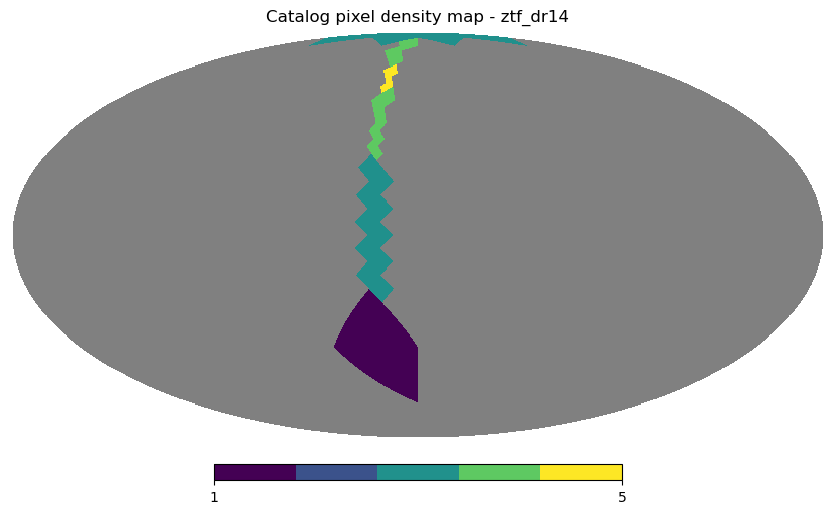

In [9]:
ztf_search_catalog = ztf_dr14.box(ra=(20, 21))
plot_pixels(ztf_search_catalog.hc_structure)

In [10]:
print(f"{ztf_search_catalog._ddf.npartitions} partitions")

41 partitions


In [11]:
%%time

ztf_partition_sizes = ztf_search_catalog._ddf.map_partitions(len).compute()
ztf_partition_sizes

CPU times: user 9.5 s, sys: 10.2 s, total: 19.7 s
Wall time: 1.79 s


0      99084
1      62528
2      29191
3      76410
4      36365
5      78642
6     101283
7      92430
8      22592
9       2041
10    118157
11     68227
12     13147
13      9538
14     75034
15     93012
16     68115
17     36529
18         0
19         0
20     46699
21     69403
22     93615
23     60143
24     19181
25      8392
26     14452
27      8075
28         0
29         0
30         0
31     41952
32     86809
33     54081
34     89437
35     49340
36     97883
37     48462
38     92669
39     51174
40     71590
dtype: int64

In [12]:
ztf_empty_partitions = ztf_partition_sizes[ztf_partition_sizes==0]
print(f"{len(ztf_empty_partitions)} empty partitions")

5 empty partitions


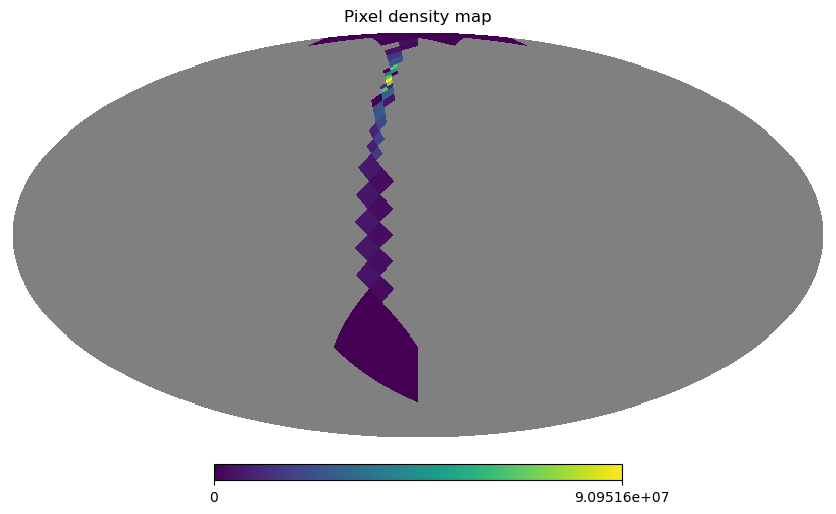

In [13]:
# Display a map of density of points per pixel (n_points / pixel_area)
plot_density_map(ztf_search_catalog._ddf_pixel_map, ztf_partition_sizes)

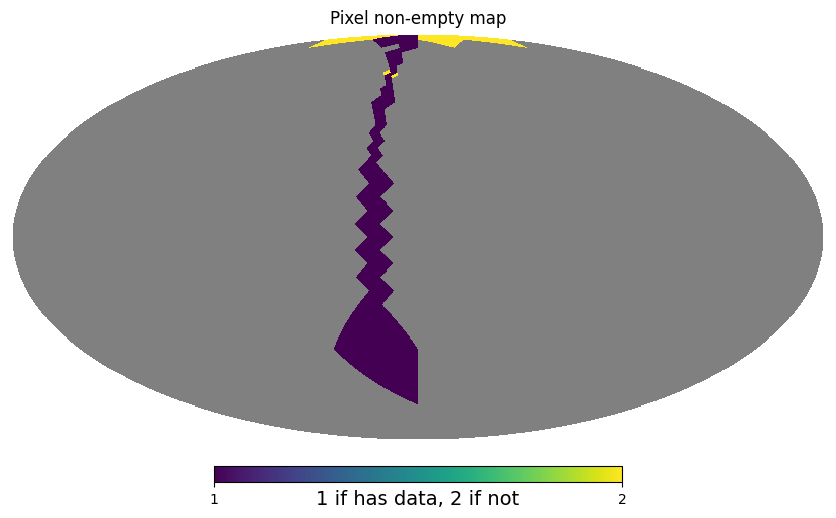

In [ ]:
plot_non_empty_pixel_map(ztf_search_catalog._ddf_pixel_map, ztf_partition_sizes)

### In Gaia

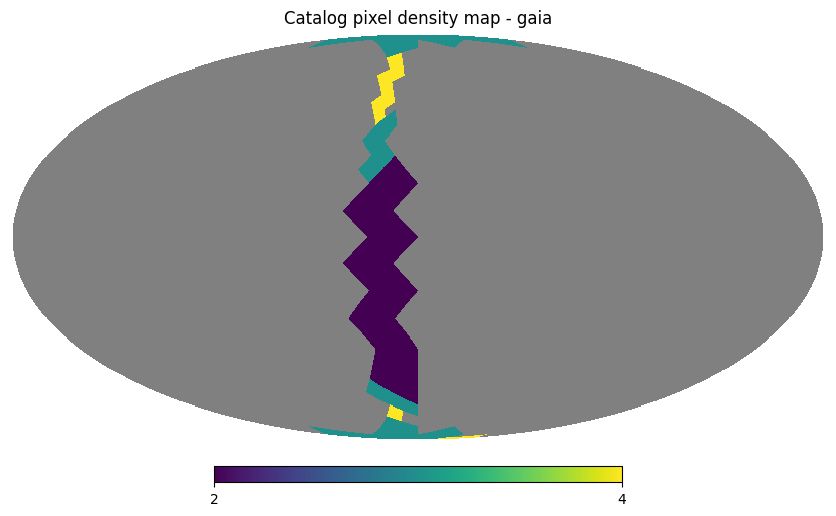

In [ ]:
gaia_search_catalog = gaia_dr3.box(ra=(20, 21))
plot_pixels(gaia_search_catalog.hc_structure)

In [ ]:
print(f"{gaia_search_catalog._ddf.npartitions} partitions")

38 partitions


In [ ]:
%%time

gaia_partition_sizes = gaia_search_catalog._ddf.map_partitions(len).compute()
gaia_partition_sizes

CPU times: user 4.51 s, sys: 1.34 s, total: 5.85 s
Wall time: 2min 58s


0      27680
1      18898
2      49195
3      32841
4      47964
5      50179
6      13417
7       1262
8      81796
9     124691
10    117664
11     24848
12         0
13     85578
14     72364
15     41749
16     27656
17      5657
18         0
19         0
20         0
21      9855
22     44958
23      9471
24     49432
25     13043
26      5786
27     18269
28     48066
29     16492
30      6915
31     10723
32     38094
33      9270
34     45829
35         0
36         0
37         0
dtype: int64

In [ ]:
gaia_empty_partitions = gaia_partition_sizes[gaia_partition_sizes==0]
print(f"{len(gaia_empty_partitions)} empty partitions")

7 empty partitions


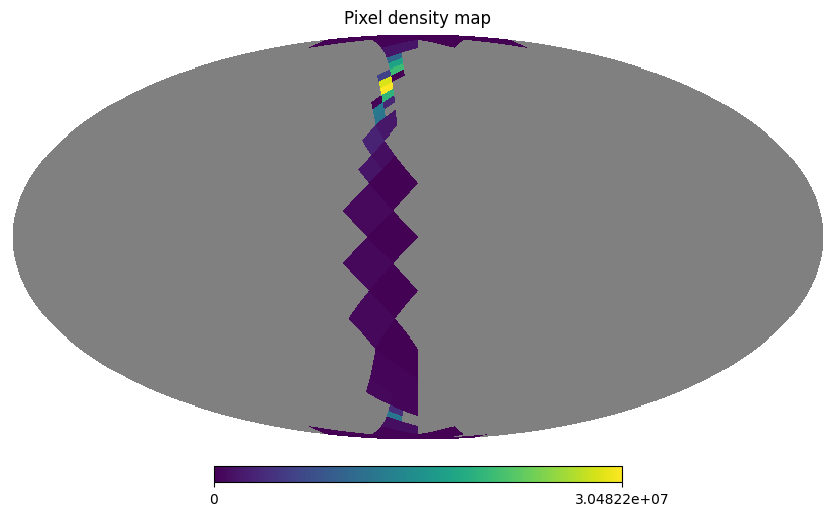

In [ ]:
# Display a map of density of points per pixel (n_points / pixel_area)
plot_density_map(gaia_search_catalog._ddf_pixel_map, gaia_partition_sizes)

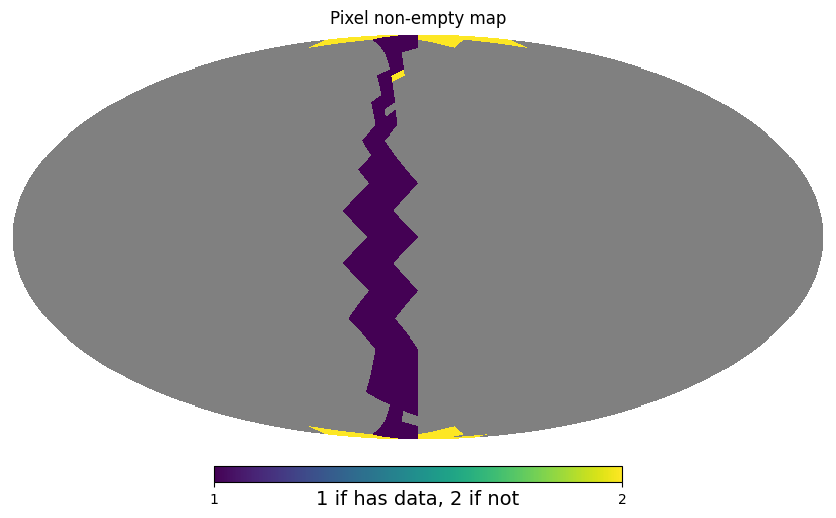

In [ ]:
plot_non_empty_pixel_map(gaia_search_catalog._ddf_pixel_map, gaia_partition_sizes)

## Filtering by DEC

### In ZTF

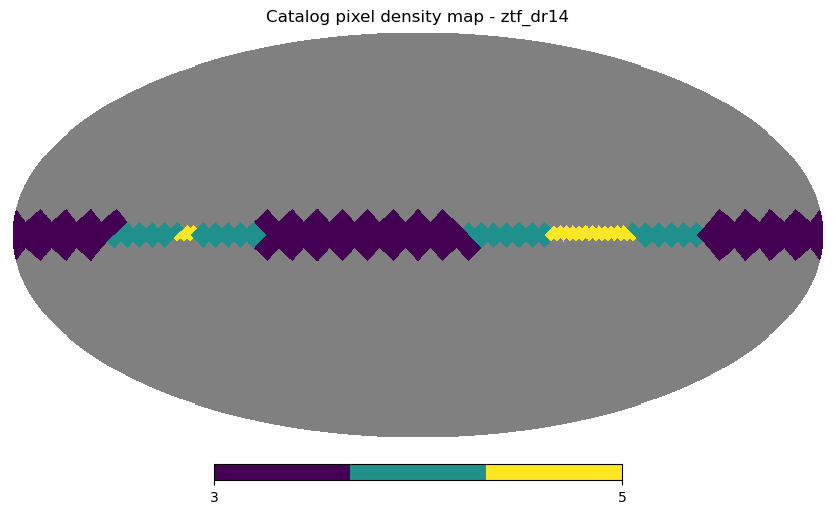

In [14]:
ztf_search_catalog = ztf_dr14.box(dec=(0, 2))
plot_pixels(ztf_search_catalog.hc_structure)

In [ ]:
print(f"{ztf_search_catalog._ddf.npartitions} partitions")

179 partitions


In [ ]:
ztf_partition_sizes = ztf_search_catalog._ddf.map_partitions(len).compute()
ztf_partition_sizes

0       68046
1       91055
2       86890
3      169994
4           0
        ...  
174     83535
175         0
176         0
177         0
178         0
Length: 179, dtype: int64

In [ ]:
empty_partitions = ztf_partition_sizes[ztf_partition_sizes==0]
print(f"There are {len(empty_partitions)} empty partitions")

There are 55 empty partitions


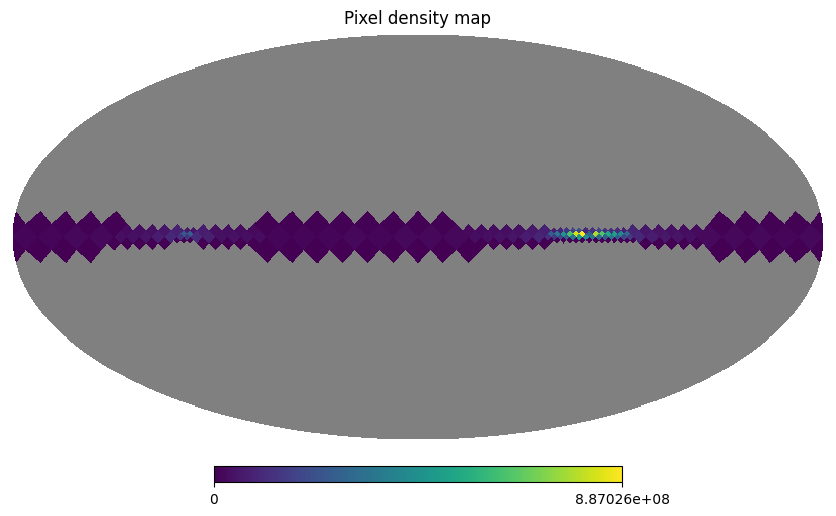

In [ ]:
# Display a map of density of points per pixel (n_points / pixel_area)
plot_density_map(ztf_search_catalog._ddf_pixel_map, ztf_partition_sizes)

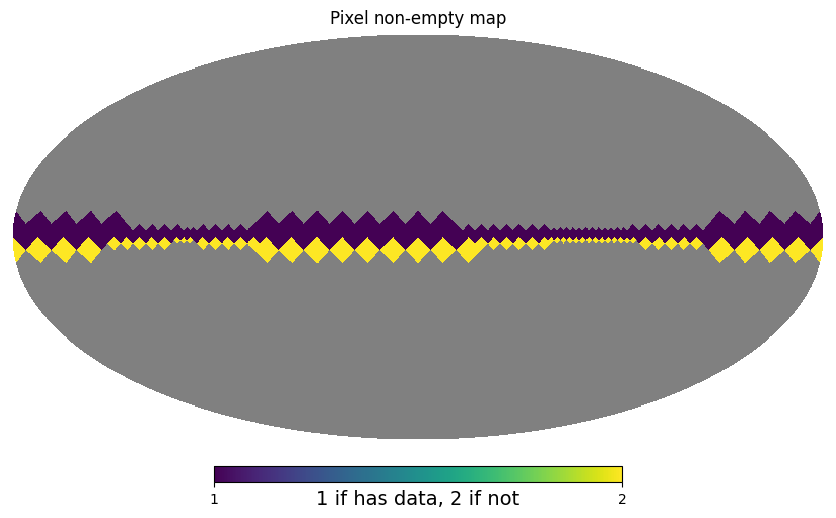

In [ ]:
plot_non_empty_pixel_map(ztf_search_catalog._ddf_pixel_map, ztf_partition_sizes)

### In Gaia

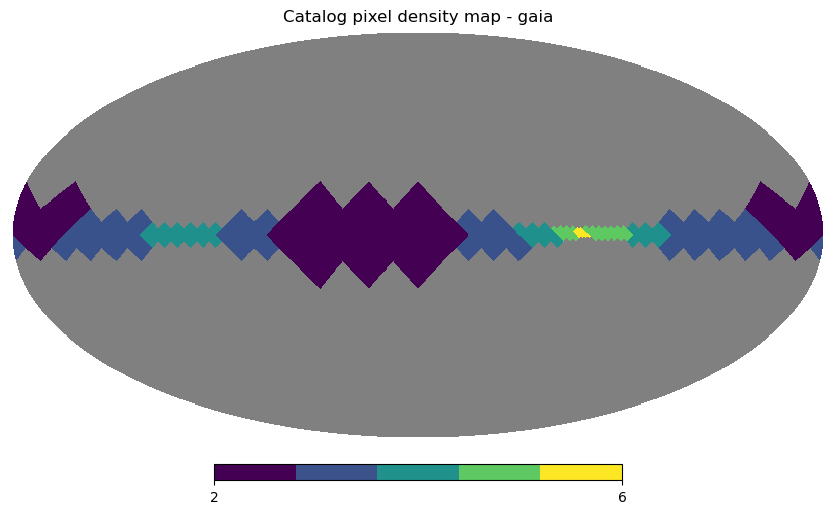

In [27]:
gaia_search_catalog = gaia_dr3.box(dec=(0, 2))
plot_pixels(gaia_search_catalog.hc_structure)

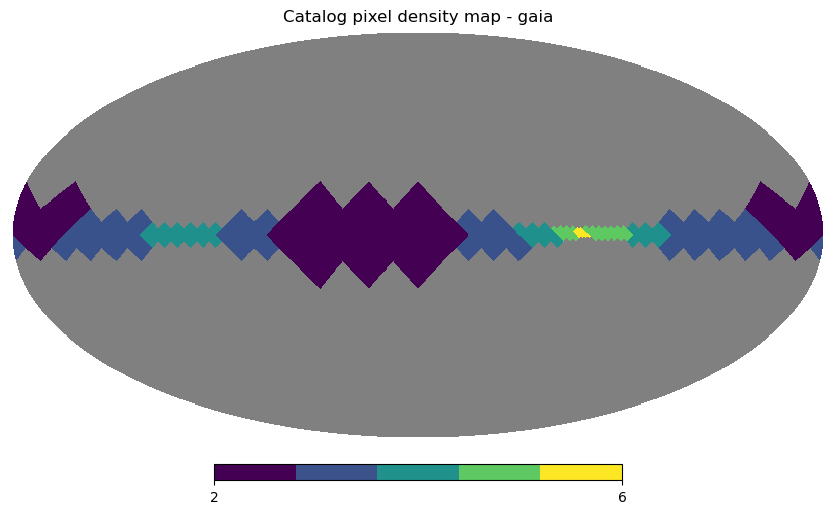

In [33]:
gaia_search_catalog_m01 = gaia_dr3.box(dec=(-.1, 2))
plot_pixels(gaia_search_catalog_m01.hc_structure)

In [28]:
print(f"{gaia_search_catalog._ddf.npartitions} partitions")

149 partitions


In [29]:
%%time

gaia_partition_sizes = gaia_search_catalog._ddf.map_partitions(len).compute()
gaia_partition_sizes

0      15036
1      32180
2      28214
3      79703
4         42
       ...  
144    64941
145       43
146       80
147       80
148      194
Length: 149, dtype: int64

In [30]:
empty_partitions = gaia_partition_sizes[gaia_partition_sizes==0]
print(f"There are {len(empty_partitions)} empty partitions")

There are 0 empty partitions


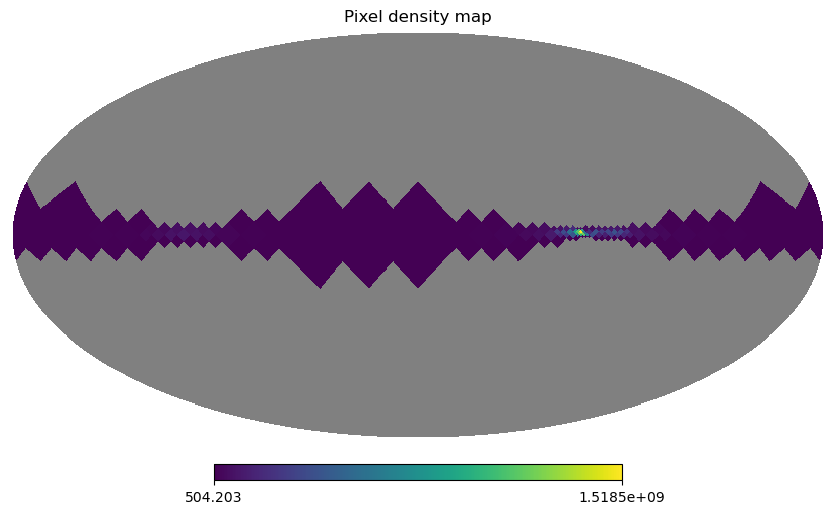

In [31]:
# Display a map of density of points per pixel (n_points / pixel_area)
plot_density_map(gaia_search_catalog._ddf_pixel_map, gaia_partition_sizes)

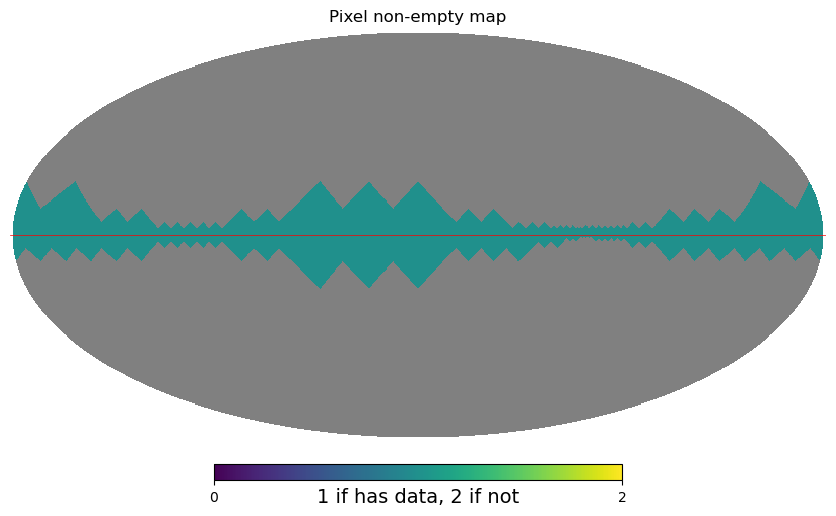

In [36]:
plot_non_empty_pixel_map(gaia_search_catalog._ddf_pixel_map, gaia_partition_sizes)
plt.axhline(0, color="red", linewidth=0.5)

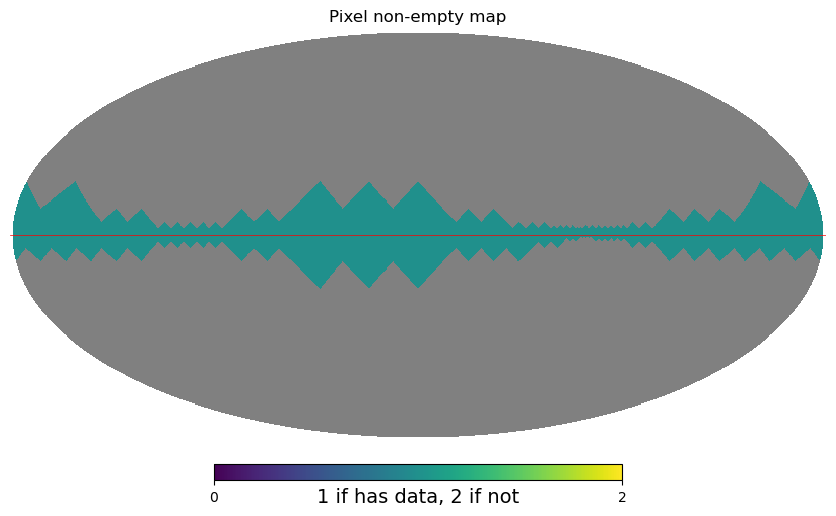

In [35]:
plot_non_empty_pixel_map(gaia_search_catalog_m01._ddf_pixel_map, gaia_partition_sizes)
plt.axhline(0, color="red", linewidth=0.5)

In [ ]:
client.close()

2024-02-15 17:01:38,085 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2024-02-15 17:01:38,086 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2024-02-15 17:01:38,087 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2024-02-15 17:01:38,087 - distributed.nanny - WARNING - Worker process still alive after 3.199999694824219 seconds, killing
